In [1]:
import random
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
import seaborn as sns
sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def distrib(m, v, tau=0.7):
    x = [comb(m, d, exact=False) * (v-1)**d / v**m * exp(-d/tau) for d in range(m+1)]
    x = np.array(x)
    x/= np.sum(x)
    return x

In [ ]:
# m = 16
# V1 = 180
# V2 = 9800
m = 16
V1 = 30
taus1 = [.2, .3, .4]
V2 = 180
taus2= [.15,.17, .2]
V3 = 9800
taus3= [0.09, 0.10, 0.12]
V4 = 300
taus4= [0.13, 0.15, 0.17]
yt = .28
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'black'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
markers = ['*', '^', 'o', 's']
for i, tau in enumerate(taus1):
    axs[0,0].plot(range(m+1) , distrib(m, V1, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,0].legend()
axs[0,0].set_xticks(4 * np.arange(m//4 +1))
axs[0,0].text(.4*m, yt, '$V_{pool}=%d$'% V1)
axs[1,0].set_xlabel('d')

for i, tau in enumerate(taus2):
    axs[0,1].plot(range(m+1),
                  distrib(m, V2, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,1].legend()
axs[0,1].set_xticks(4 * np.arange(m//4 +1))
axs[0,1].text(.4*m, yt, '$V_{pool}=%d$'% V2)
axs[0,1].set_xlabel('d')

for i, tau in enumerate(taus3):
    axs[1,0].plot(range(m+1),
                  distrib(m, V3, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,0].legend()
axs[1,0].set_xticks(4 * np.arange(m//4 +1))
axs[1,0].text(.4*m, yt, '$V_{pool}=%d$'% V3)
axs[1,0].set_xlabel('d')


m = 50
for i, tau in enumerate(taus4):
    axs[1,1].plot(range(m+1),
                  distrib(m, V4, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,1].legend()
axs[1,1].set_xticks(4 * np.arange(m//4 +1))
axs[1,1].text(.4*m, yt, '$V_{pool}=%d$'% V4)
axs[1,1].set_xlabel('d')
plt.tight_layout()

plt.savefig('../figures/hamming_q.png', dpi=400, bbox_inches='tight')

## word neighbors

In [71]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]

# utils:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def invocab(ngram):
    for w in ngram:
        if w not in MATCH:
            return False
    return True

def space(xy, points, delta=1):
    x , y = xy
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    while np.any(np.absolute(xs -x) < delta):
        x += delta
    while np.any(np.absolute(ys -y) < delta):
        y += delta
    return [x, y]

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
sim_wiki = pickle.load(open('../data/Glove/glove_wiki_d300_w15_similarities.pkl',
                             'rb'), encoding='iso-8859-1')
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))


F: (9488,)


In [152]:
def plot_word_neighbors(axs, selected, sim, prefix, NN=8, verbose=0, xlab=0):
    sns.set()
    ax2, ax = axs
    h = .05
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected]
    nbrs = np.flip(sim[k].argsort()[-NN:][::-1], axis=0)
    wnbrs = [WORDS[i] for i in nbrs]
#     simnbrs = [sim[k,k] - sim[k,i] for i in nbrs]
    simnbrs = [sim[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(NN)
    ax2.get_shared_y_axes().join(ax, ax2)
    ax2.set_xlim(1e-6, 1)
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()
    freqnbrs = [F[i] for i in nbrs]
    if verbose:
        print('freq', freqnbrs)
        print('sim', simnbrs)
    ax2.barh(ys, freqnbrs, height=h,
             align='edge', color="steelblue", alpha=.7)
    
    ax2.set_xscale("log", nonposx='clip')
    ax2.axis('off')
    ax.barh(ys, [0] * (NN-1) + [1], height=h, align='edge', color="darkred", alpha=.5)
    ax.barh(ys, simnbrs, height=h, align='edge', color="darkgray", alpha=.7)
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    ax.set_xlim(1e-4, 1)
    ax.set_xscale("log", nonposx='clip')
    if xlab:
        ax.set_xlabel('$r_\\tau(y|$%s$)$' % selected)
        ax2.set_xlabel('freq')
    ax.set_title("%s" % (prefix), fontsize=16)
    plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')


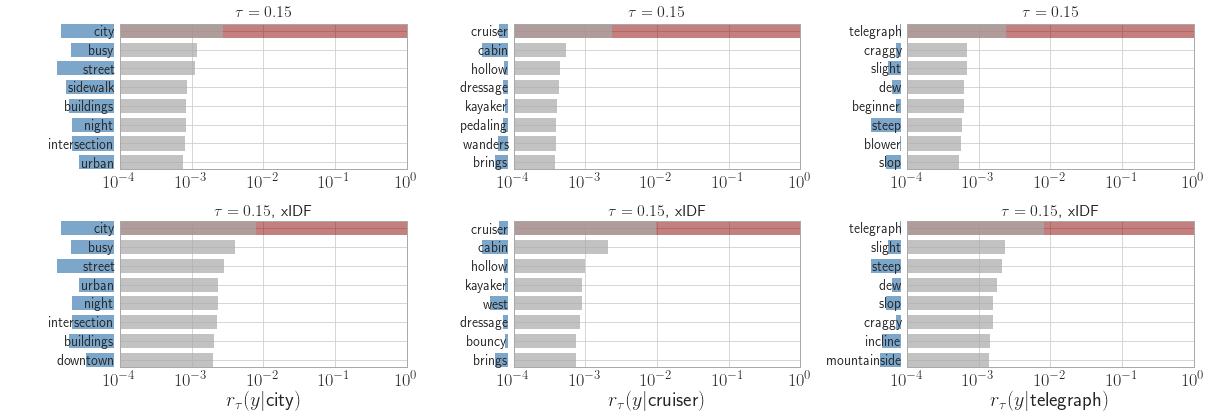

In [169]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(2, 6, figsize=(17, 6),
#                         figsize=(17, 10),
                        gridspec_kw = {'width_ratios':[1, 3] * 3})
# fig.suptitle("forest's top neighbors", fontsize=16)
word = "city" #"street"
# plot_word_neighbors(axs[0,:2], word, exps(sim_wiki, 0.15),
#                     'Glove Wiki, $\\tau=0.15$')
plot_word_neighbors(axs[0,:2], word, exps(sim_coco, 0.15),
                    '$\\tau=0.15$')
plot_word_neighbors(axs[1,:2], word, exps(sim_coco, 0.09, True),
                    '$\\tau=0.15$, xIDF',
                    xlab=1)

word = "cruiser" 
# plot_word_neighbors(axs[0,2:4], word, exps(sim_wiki, 0.15),
#                     'Glove Wiki, $\\tau=0.15$')
plot_word_neighbors(axs[0,2:4], word, exps(sim_coco, 0.15),
                    '$\\tau=0.15$')
plot_word_neighbors(axs[1,2:4], word, exps(sim_coco, 0.09, True),
                    '$\\tau=0.15$, xIDF',
                    xlab=1)

word = "telegraph" # "choir"
# plot_word_neighbors(axs[0,4:], word, exps(sim_wiki, 0.15),
#                     'Glove Wiki, $\\tau=0.15$')
plot_word_neighbors(axs[0,4:], word, exps(sim_coco, 0.15),
                    '$\\tau=0.15$')
plot_word_neighbors(axs[1,4:], word, exps(sim_coco, 0.09, True),
                    '$\\tau=0.15$, xIDF',
                    xlab=1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.03)

plt.savefig('../figures/words_nbrs_coco.png',
            dpi=300, bbox_inches='tight')


In [ ]:
frequent = F.argsort()[-80:][::-1]
for fr in frequent:
    print(WORDS[fr],)

In [159]:
medium = F.argsort()[2000:2030]
for fr in medium:
    print(WORDS[fr],)

walkways
dollars
provided
kilt
merging
ranges
erase
trooper
cork
shrine
piggy
receipt
comforters
bouquets
warped
alien
linger
appreciating
cemetary
flickr
belonging
horrible
airports
strokes
mustang
barges
blinder
kart
pride
lanyard


In [162]:
rare = F.argsort()[60:90]
for fr in rare:
    print(WORDS[fr],)

maps
carport
funnel
tequila
monte
sonic
bourbon
carnation
poem
resident
malaysia
limousine
monroe
toasters
halo
applesauce
birdbath
app
minnie
juicing
pinking
duke
binoculars
marilyn
buttery
indiana
autographed
telegraph
foreheads
gong


In [63]:
def skim(arr, percentile):
    th = np.percentile(arr, percentile)
    arr[arr<th] = 0
    return arr

def plot_nbrs_picks(word, ax, legend=False):
    iw = MATCH[word]
    dirac = np.zeros(sim_coco.shape[0])
    dirac[MATCH[word]] = 1
    ax.plot(dirac, c='darkred', alpha=0.5, label="MLE - $\\delta$")

    default = skim(exps(sim_coco, 0.15, False)[iw], 98)
    ax.plot(default, c='darkgreen', label="Tok-Reward - $r_\\tau$", alpha=.5)

    xidf = skim(exps(sim_coco, 0.15, True)[iw], 98)
    ax.plot(xidf, c='mediumblue', label="Tok-Reward - $r_\\tau^{IDF}$", alpha=.5)
    if legend:
        ax.legend(fontsize=15, loc=2)
    wxidf = np.nonzero(xidf)[0]
    wdef = np.nonzero(default)[0]
    wperr = 4
    sel = np.concatenate((np.array([iw]),
                          np.random.choice(wdef, wperr),
                          np.random.choice(wxidf, wperr)))
    colors = ['darkred'] + wperr * ['darkgreen'] + wperr * ['mediumblue']
    for e, (s, c) in enumerate(zip(sel, colors)):
#         print('index:', s, 'default', default[s], 'xidf', xidf[s])
        if not e:
            scale=.5
            slide = 25
            pick = 1
        else:
            if e < wperr + 1:
                pick = default[s]
                slide = -400
                scale = 5
#                 print('e:', e, WORDS[s])
            else:
                pick = xidf[s]
                slide = 100
                scale = 3

        ax.annotate(WORDS[s].encode().decode(),
                    xy=(s, pick),
                    xytext=(s + slide, scale * pick),
                    color=c,
                    fontsize=18,
    #               arrowprops=dict(facecolor='black', shrink=0.05),
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    facecolor=c,
                                    edgecolor=c))
    ax.set_yscale("log")
    ax.set_xticks([])
    ax.set_ylabel('$r_\\tau(y|$%s$)$' % word)
#     ax.set_xlabel('$\\mathcal V$')


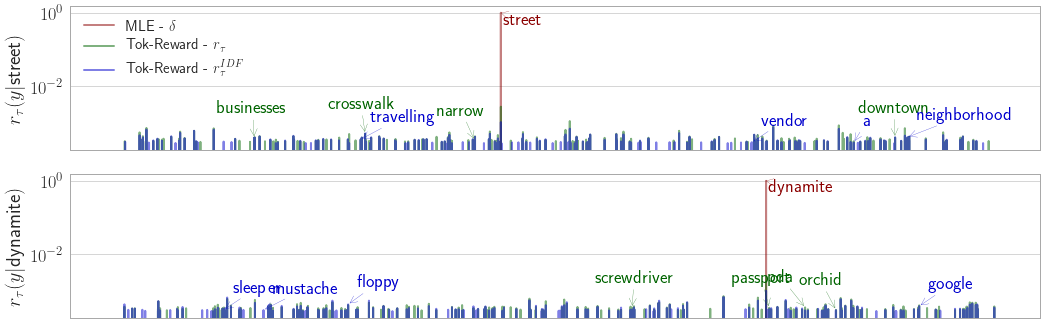

In [117]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, axs = plt.subplots(2, 1, figsize=(15, 5))
np.random.seed(1244)
plot_nbrs_picks('street', axs[0], legend=True)

np.random.seed(17)
plot_nbrs_picks('dynamite', axs[1])

plt.tight_layout()
# plt.savefig('../figures/nbrs_picks.png',
#             dpi=300, bbox_inches='tight')

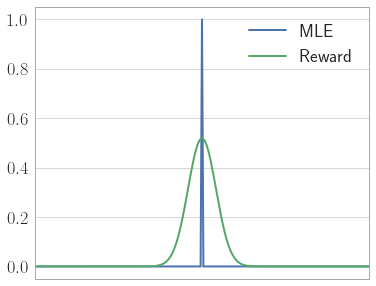

In [221]:
L = 800
x = np.arange(L)
y = np.zeros(L)
center = 300
a = 1e-5
y = 1/a * (1/np.pi * 1/(1+((x- center)/a)**2))
y /= np.sum(y)

if 0:
    centers = [center] + np.random.randint(low=1,
                                           high=L,
                                           size=10)
    sigmas = np.random.randint(low=1,
                               high=10,
                               size=10) / 10
    weights = [5] + np.random.randint(low=1,
                                      high=10,
                                      size=10)/2
    weights = weights / np.sum(weights)
    z = np.zeros(L)
    for w, c, s in zip(weights, centers, sigmas):
        z += w * np.exp(-(x-c)**2/2/s)
    # z += 1/30 * np.random.randn(50)
if 1:
    sigma = 10
    z = np.exp(-(x-center)**2/2/sigma**2)
z /= np.sum(z)
z = 13 * z
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
plt.figure(figsize=(6,5))
plt.plot(x, y, label='MLE')
plt.plot(x, z, label='Reward')
plt.xlim([center-12*sigma, center+12*sigma])
plt.xticks([])
plt.legend()
# plt.xticks(centers, ['jungle', 'forest', 'clearing'], rotation=45)
